In [51]:
#import packages
import vedo
import k3d
import numpy as np
import pandas as pd
import json
import glob
import os
import networkx as nx
import ast
from nxviz import utils
from operator import itemgetter
from skimage import img_as_uint, exposure
from skimage.io import imread
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import CCFv3 template reference lists of all experimental groups

WT_ctrl_list = pd.read_csv("WT_ctrl_list.csv", index_col = 0)
Tbr1_ctrl_list= pd.read_csv("Tbr1_ctrl_list.csv", index_col = 0)
WT_TBS_list= pd.read_csv("WT_TBS_list.csv", index_col = 0)
Tbr1_TBS_list= pd.read_csv("Tbr1_TBS_list.csv", index_col = 0)

In [3]:
#subset reference list for 3D mapping of oChIEF signals

WT_ctrl_oChIEFlist = WT_ctrl_list.drop("022121 Tbr1 wt 3 nost", axis = 1)
Tbr1_ctrl_oChIEFlist = Tbr1_ctrl_list.drop("041821 Tbr1 21 nost", axis = 1)
WT_TBS_oChIEFlist = WT_TBS_list
Tbr1_TBS_oChIEFlist = Tbr1_TBS_list

#combine oChIEF reference list
WT_oChIEF_list = pd.concat([WT_ctrl_oChIEFlist, WT_TBS_oChIEFlist], axis = 1)
Tbr1_oChIEF_list = pd.concat([Tbr1_ctrl_oChIEFlist, Tbr1_TBS_oChIEFlist], axis = 1)

WT_oChIEF_list_m = pd.melt (WT_oChIEF_list)
WT_slice_list = np.unique (WT_oChIEF_list_m["value"].dropna().astype("int"))
Tbr1_oChIEF_list_m = pd.melt (Tbr1_oChIEF_list)
Tbr1_slice_list = np.unique (Tbr1_oChIEF_list_m["value"].dropna().astype("int"))

In [6]:
#generate region_masked oChIEF distribution dataframe
#Example: Figure 2D WT

#loading structure list for ploting
volume_based_analysis = pd.read_csv("table_s1.csv", index_col =0)
ipsilateral_list = volume_based_analysis[volume_based_analysis["Ipsi. volume-based analysis oChIEF U test P value"]<0.05].index.tolist()
contralateral_list = volume_based_analysis[volume_based_analysis["Contra. volume-based analysis oChIEF U test P value"]<0.05].index.tolist()


#generate region_masked oChIEF distribution dataframe function

structure_list_dropempty = pd.read_csv("CCFv3/structuretree/structure_list_paper.csv", index_col = None)

ROI_corrected_structure_L =  ["LA", "BLA", "amc", "VISam", "CP", "AI", "VISC", "ORBvl", "TEa", "AIp", "ORBl", "ACAd", "BLAa",
                              "AUD", "ACAv", "PL", "ILA", "RSPv", "RSPd", "RSPagl", "VISa", "MOs", "SSp-tr", "SSp-ll", "act", "ORBm", "PP",
                              "CM", "RH", "PCN", "PF", "CL", "PIL", "AUDd", "AUDv", "PVpo",
                              "RSP", "ORB", "ACA", "ILM", "AId", "VTA", "RE", "BLAp"]

ROI_corrected_structure_R = ["LA", "BLA", "ORBvl", "PBG", "SAG", "FRP", "APr", "VISam", "scp", "CP", "AI", "VISC", "TEa", "AIp", "ORBl", "ACAd", "BLAa",
                             "AUD", "ORBm", "ACAv", "PL", "ILA", "RSPv", "RSPd", "RSPagl", "VISa", "MOs", "SSp-tr", "SSp-ll", "PPN", "PP", "RCH", "ORBm",
                             "CM", "RH", "PCN", "PF", "CL", "PIL", "AUDd", "AUDv", "DG", "VTA",
                             "RSP", "ORB", "ACA", "ILM", "AId", "PVpo", "RE"]


def create_structure_average_mask_L (genotype, slice_list, reference_list, structure_list):
    pd_all = pd.DataFrame()
    for structure in structure_list:
        mask_n_list = [b for b in json.loads(structure_list_dropempty["section_number"][structure_list_dropempty[structure_list_dropempty.LABEL==structure].index[0]]) if b in slice_list]
        img_mask_stack=[]
        for c in slice_list:
            if c not in mask_n_list:
                mask_b = np.zeros ([800, 1140])
                img_mask_stack.append(mask_b)
            else:             
                if structure in ROI_corrected_structure_L:
                    file_path_list = []
                    for name_L in glob.glob("quantification/"+genotype+"/*/mask_L/"+structure+"/*"):
                        path_L,folder_name_L = os.path.split(name_L)
                        if folder_name_L in reference_list.columns:
                            for root_L, dirs_L, files_L in os.walk (name_L):
                                for file_L in files_L:
                                    if file_L.endswith ("mask"+str(c)+".tif"):
                                        file_path_L = os.path.join(root_L, "mask"+str(c)+".tif")
                                        file_path_list.append(file_path_L)
                    average_img_L = np.zeros((800, 570))
                    n_L = len(file_path_list)
                    for im_L in file_path_list:
                        imarr_L = np.array(imread (im_L))
                        average_img_L = average_img_L + imarr_L/n_L
                    average_img_r_L = exposure.rescale_intensity(average_img_L, out_range='float')
                    average_img = img_as_uint(np.concatenate((average_img_r_L, np.zeros((800, 570))), axis = 1))/65535
                    img =imread("quantification/"+genotype+"_small_oChIEF_b_average_folder/oChIEF_sb"+"%04d"%c+".tif")
                    img_mask = average_img*img
                    img_mask_stack.append (img_mask)
                    
                else: 
                    #CCFv3 coronal masks are downloaded through AllenSDK https://allensdk.readthedocs.io/en/latest/_static/examples/nb/reference_space.html
                    file_path = "/Volumes/My Passport/CCFv3/mask/mask"+str(structure_list_dropempty[structure_list_dropempty["LABEL"]==structure]["IDX"].values[0])+"/" 
                    for root_L, dirs_L, files_L in os.walk (file_path):
                        for file_L in files_L:
                            if file_L.endswith("mask"+str(c)+".csv"):
                                file_path_L = os.path.join(root_L, "mask"+str(c)+".csv")
                                imarr_L = pd.read_csv(file_path_L, header = 0, index_col = 0).values[:, :570]
                                average_img_r_L = exposure.rescale_intensity(imarr_L, out_range='float')
                                average_img = img_as_uint(np.concatenate((average_img_r_L, np.zeros((800, 570))), axis = 1))/65535
                                img =imread("quantification/"+genotype+"_small_oChIEF_b_average_folder/oChIEF_sb"+"%04d"%c+".tif") #data will be avaiable after publication
                                img_mask = average_img*img
                                img_mask_stack.append (img_mask)
                            
        np_img = np.array(img_mask_stack)
        z, y, x = np.where(np_img>0)
        pd_loc = pd.DataFrame({"z":z, "y":y, "x":x})

        img_value_list =[]
        for indexa, varaa in pd_loc.iterrows():
            img_value = np_img[varaa["z"]][varaa["y"]][varaa["x"]]
            img_value_list.append(img_value)

        if len(img_value_list)>0:
            pd_loc["alpha"] = (img_value_list/max(img_value_list))*100
        else:
            pd_loc["alpha"] = 0
        pd_loc["value"] = img_value_list
        pd_loc["x"] = pd_loc["x"].values*10
        pd_loc["y"] = pd_loc["y"].values*10
        pd_loc["z"] = slice_list[pd_loc["z"].values]*10
        pd_loc["R"] = structure_list_dropempty[structure_list_dropempty["LABEL"]==structure]["-R-"].values[0]
        pd_loc["G"] = structure_list_dropempty[structure_list_dropempty["LABEL"]==structure]["-G-"].values[0]
        pd_loc["B"] = structure_list_dropempty[structure_list_dropempty["LABEL"]==structure]["-B-"].values[0]
        pd_loc["structure"]=structure
        pd_loc["hemisphere"]="contra"
        pd_all = pd.concat([pd_all, pd_loc], axis = 0)
    return pd_all

def create_structure_average_mask_R (genotype, slice_list, reference_list, structure_list):
    pd_all = pd.DataFrame()
    for structure in structure_list:
        mask_n_list = [b for b in json.loads(structure_list_dropempty["section_number"][structure_list_dropempty[structure_list_dropempty.LABEL==structure].index[0]]) if b in slice_list]
        img_mask_stack=[]
        for c in slice_list:
            if c not in mask_n_list:
                mask_b = np.zeros ([800, 1140])
                img_mask_stack.append(mask_b)
            else:             
                if structure in ROI_corrected_structure_R:
                    file_path_list = []
                    for name_R in glob.glob("quantification/"+genotype+"/*/mask_R/"+structure+"/*"):
                        path_R,folder_name_R = os.path.split(name_R)
                        if folder_name_R in reference_list.columns:
                            for root_R, dirs_R, files_R in os.walk (name_R):
                                for file_R in files_R:
                                    if file_R.endswith ("mask"+str(c)+".tif"):
                                        file_path_R = os.path.join(root_R, "mask"+str(c)+".tif")
                                        file_path_list.append(file_path_R)
                    average_img_R = np.zeros((800, 570))
                    n_R = len(file_path_list)
                    for im_R in file_path_list:
                        imarr_R = np.array(imread (im_R))
                        average_img_R = average_img_R + imarr_R/n_R
                    average_img_r_R = exposure.rescale_intensity(average_img_R, out_range='float')
                    average_img = img_as_uint(np.concatenate((np.zeros((800, 570)), average_img_r_R), axis = 1))/65535
                    img =imread("quantification/"+genotype+"_small_oChIEF_b_average_folder/oChIEF_sb"+"%04d"%c+".tif")
                    img_mask = average_img*img
                    img_mask_stack.append (img_mask)
                    
                else:
                    #CCFv3 coronal masks are downloaded through AllenSDK https://allensdk.readthedocs.io/en/latest/_static/examples/nb/reference_space.html
                    file_path = "/Volumes/My Passport/CCFv3/mask/mask"+str(structure_list_dropempty[structure_list_dropempty["LABEL"]==structure]["IDX"].values[0])+"/"
                    for root_R, dirs_R, files_R in os.walk (file_path):
                        for file_R in files_R:
                            if file_R.endswith("mask"+str(c)+".csv"):
                                file_path_R = os.path.join(root_R, "mask"+str(c)+".csv")
                                imarr_R = pd.read_csv(file_path_R, header = 0, index_col = 0).values[:, 570:]
                                average_img_r_R = exposure.rescale_intensity(imarr_R, out_range='float')
                                average_img = img_as_uint(np.concatenate((np.zeros((800, 570)), average_img_r_R), axis = 1))/65535                            
                                img =imread("quantification/"+genotype+"_small_oChIEF_b_average_folder/oChIEF_sb"+"%04d"%c+".tif") #data will be avaiable after publication                             
                                img_mask = average_img*img
                                img_mask_stack.append (img_mask)
                            
        np_img = np.array(img_mask_stack)
        z, y, x = np.where(np_img>0)
        pd_loc = pd.DataFrame({"z":z, "y":y, "x":x})

        img_value_list =[]
        for indexa, varaa in pd_loc.iterrows():
            img_value = np_img[varaa["z"]][varaa["y"]][varaa["x"]]
            img_value_list.append(img_value)

        if len(img_value_list)>0:
            pd_loc["alpha"] = (img_value_list/max(img_value_list))*100
        else:
            pd_loc["alpha"] = 0
        pd_loc["value"] = img_value_list
        pd_loc["x"] = pd_loc["x"].values*10
        pd_loc["y"] = pd_loc["y"].values*10
        pd_loc["z"] = slice_list[pd_loc["z"].values]*10
        pd_loc["R"] = structure_list_dropempty[structure_list_dropempty["LABEL"]==structure]["-R-"].values[0]
        pd_loc["G"] = structure_list_dropempty[structure_list_dropempty["LABEL"]==structure]["-G-"].values[0]
        pd_loc["B"] = structure_list_dropempty[structure_list_dropempty["LABEL"]==structure]["-B-"].values[0]
        pd_loc["structure"]=structure
        pd_loc["hemisphere"]="ipsi"
        pd_all = pd.concat([pd_all, pd_loc], axis = 0)
    return pd_all

WT_contra= create_structure_average_mask_L ("WT", WT_slice_list, WT_oChIEF_list, contralateral_list)
WT_ipsi= create_structure_average_mask_R ("WT", WT_slice_list, WT_oChIEF_list, ipsilateral_list)
WT_oChIEF_U = pd.concat([WT_contra, WT_ipsi], axis = 0)

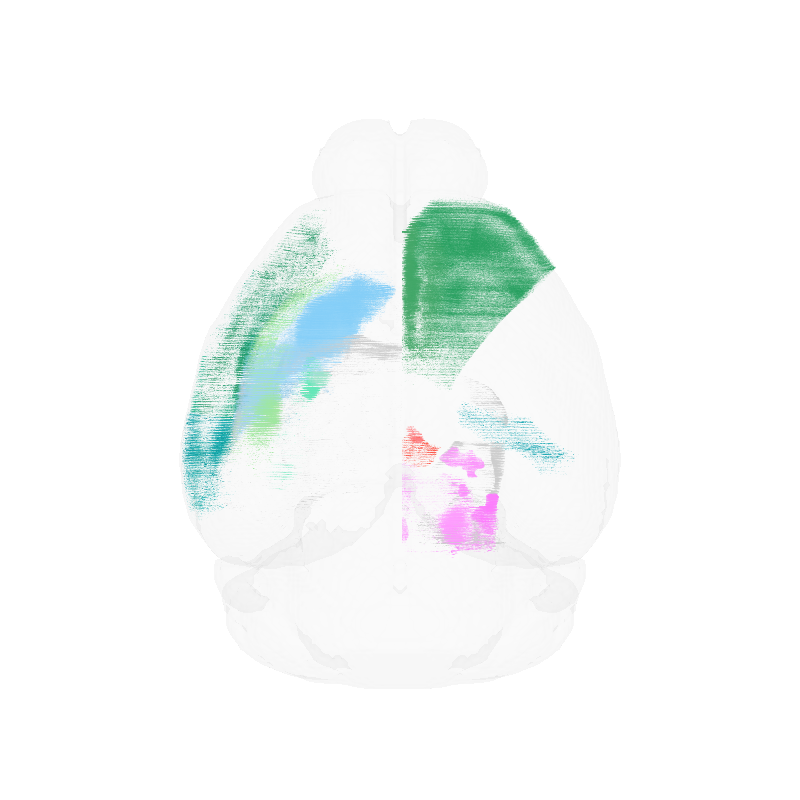

In [5]:
#3D mapping of oChIEF distributions
#Example: Figure 2D WT
root = vedo.load("root_small.vtk")
root.cmap("gray_r").alpha(0.1).lighting("ambient")
pts = vedo.Points(WT_oChIEF_U[["z","y", "x"]].values, c = WT_oChIEF_U[["R","G", "B", "alpha"]].values).point_size(0.01)

#show 3D mapping
vedo.settings.default_backend ='2d'
vedo.show(root, pts, azimuth=0, elevation=-90, roll=270, resetcam = True, zoom = 1, size=(800, 800))

In [7]:
#3D mapping of oChIEF difference distributions (Figure 4A, C left panel)
ipsi_list = ['HIP', 'MOp', 'AUDd', 'ACA', 'ACAv', 'VISa', 'TEa', 'MEA',
             'PALv', 'SI', 'PALc', 'BST', 'DORsm', 'DORpm', 'CL', 'LZ', 'VTA']
contra_list = ['AUD', 'AIp', 'PIR', 'BLA', 'PALv', 'SI', 'DORsm', 'ILM']

WT_contra= create_structure_average_mask_L ("WT", WT_slice_list, WT_oChIEF_list, contra_list)
WT_ipsi= create_structure_average_mask_R ("WT", WT_slice_list, WT_oChIEF_list, ipsi_list)
WT_oChIEF_U = pd.concat([WT_contra, WT_ipsi], axis = 0)

Tbr1_contra= create_structure_average_mask_L ("Tbr1", Tbr1_slice_list, Tbr1_oChIEF_list, contra_list)
Tbr1_ipsi= create_structure_average_mask_R ("Tbr1", Tbr1_slice_list, Tbr1_oChIEF_list, ipsi_list)
Tbr1_oChIEF_U = pd.concat([Tbr1_contra, Tbr1_ipsi], axis = 0)

WT_ipsi = WT_oChIEF_U[WT_oChIEF_U["hemisphere"]=="ipsi"]
WT_contra = WT_oChIEF_U[WT_oChIEF_U["hemisphere"]=="contra"]
Tbr1_ipsi = Tbr1_oChIEF_U[Tbr1_oChIEF_U["hemisphere"]=="ipsi"]
Tbr1_contra = Tbr1_oChIEF_U[Tbr1_oChIEF_U["hemisphere"]=="contra"]

WT_ipsi["xyz"]=[(varaa["z"], varaa["y"], varaa["x"]) for indexa, varaa in WT_ipsi.iterrows()]
Tbr1_ipsi["xyz"]=[(varaa["z"], varaa["y"], varaa["x"]) for indexa, varaa in Tbr1_ipsi.iterrows()]
WT_ipsi.set_index(["xyz"], inplace = True)
Tbr1_ipsi.set_index(["xyz"], inplace = True)
WT_ipsi_down_group = WT_ipsi.groupby(WT_ipsi.index).mean()
Tbr1_ipsi_down_group = Tbr1_ipsi.groupby(Tbr1_ipsi.index).mean()

WT_contra["xyz"]=[(varaa["z"], varaa["y"], varaa["x"]) for indexa, varaa in WT_contra.iterrows()]
Tbr1_contra["xyz"]=[(varaa["z"], varaa["y"], varaa["x"]) for indexa, varaa in Tbr1_contra.iterrows()]
WT_contra.set_index(["xyz"], inplace= True)
Tbr1_contra.set_index(["xyz"], inplace = True)
WT_contra_down_group = WT_contra.groupby(WT_contra.index).mean()
Tbr1_contra_down_group = Tbr1_contra.groupby(Tbr1_contra.index).mean()

In [8]:
#create oChIEF difference pixels
#Example:Figure 4C left panel

def oChIEF_pixel_diff (df1, df2):

    common_xyz = list(set(df1.index.tolist()).intersection(set(df2.index.tolist())))
    diff = df2.loc[common_xyz, "value"]-df1.loc[common_xyz, "value"]
    diff_pd = pd.DataFrame({"xyz":common_xyz, "diff":diff.tolist()})
    return diff_pd

diff_oChIEF_ipsi = oChIEF_pixel_diff (WT_ipsi_down_group, Tbr1_ipsi_down_group)

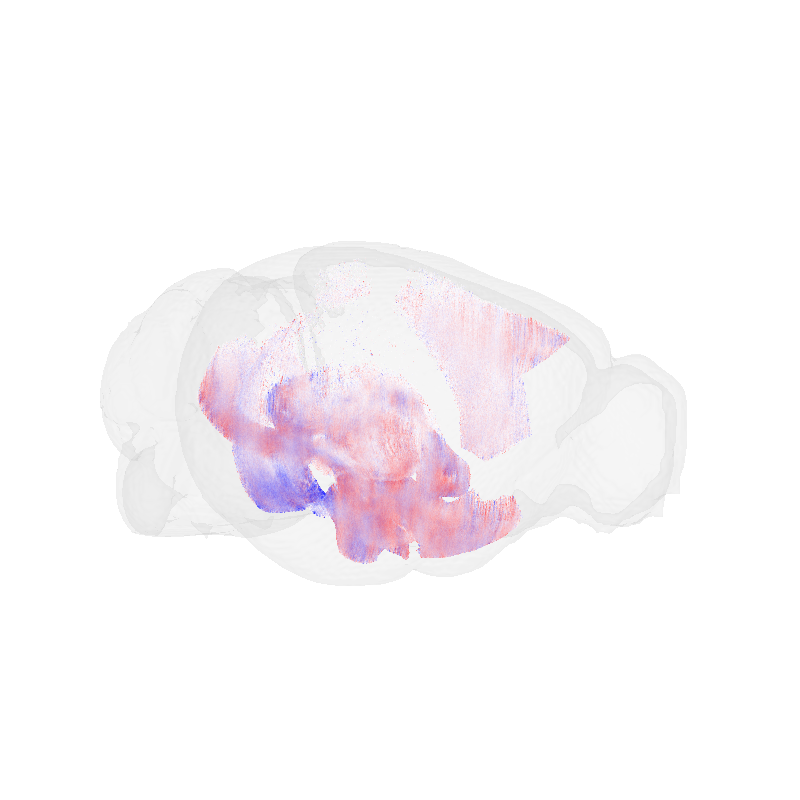

In [25]:
#3D mapping of oChIEF distributions
#Example:Figure 4C left panel

xyz_list = diff_oChIEF_ipsi["xyz"].tolist()
diff_list = diff_oChIEF_ipsi["diff"].tolist()
vmin, vmax = np.min(diff_list), np.max(diff_list)
scale = abs(vmax-vmin)
scale_diff = diff_list/scale

color = [vedo.color_map(v, "bwr", -0.1, 0.1) for v in scale_diff]
s = vedo.Points(np.array(xyz_list), c = color, alpha=0.5).point_size(1)
root = vedo.load("root_small.vtk")
root.cmap("gray_r").alpha(0.2).lighting("ambient")

#show 3D mapping
vedo.settings.default_backend ='2d'
vedo.show(root, s, azimuth=-20, elevation=-10, roll=180, resetcam = True, zoom = 1, size = (800,800))

In [26]:
#combine cfos_spots of the same genotype 

def concat_cfos_spot (genotype, st_pattern, reference_list):
    """combine C-FOS_spots of the same experimental groups"""
    
    cfos_spot_all = []
    
    for h in reference_list.columns:
        structure_path = "quantification/"+ genotype+"/"+st_pattern +"/"+h +"/rre_cfos_spot_location.csv" #data will be avaiable after publication
        
        cfos_spot = pd.read_csv (structure_path)
        cfos_spot.drop (["x (pixels)", "y(pixels)", "z(pixels)"], axis = 1, inplace = True)
        cfos_spot_all.append (cfos_spot)
        
    return pd.concat (cfos_spot_all)

WT_cfos_ctrl_spot = concat_cfos_spot ("WT", "ctrl", WT_ctrl_list)
Tbr1_cfos_ctrl_spot = concat_cfos_spot ("Tbr1", "ctrl", Tbr1_ctrl_list)
WT_cfos_TBS_spot = concat_cfos_spot ("WT", "TBS", WT_TBS_list)
Tbr1_cfos_TBS_spot = concat_cfos_spot ("Tbr1", "TBS", Tbr1_TBS_list)

In [27]:
#binning cfos_spot by quantization scale micrometer and add structure name
structure_original = pd.read_csv ("CCFv3/structuretree/structuretree_original.csv", index_col = 0)

def scale_down (df, scale_level, reference_list):
    """scale down cfos_spot by quantization defined micrometer and add structure name"""
    df = df.drop(["Unnamed: 0", "Unnamed: 0.1", "Unnamed: 0.2"], axis = 1)
    df[["x(micrometer)", "y(micrometer)", "z(micrometer)"]]//=scale_level
    df[["x(micrometer)", "y(micrometer)", "z(micrometer)"]]*=scale_level
    df = df.groupby (df.columns.tolist(), as_index = False).size()
    df["Density (cells/cubic millimeter)"]= (df["size"]/((scale_level*0.001)**3))/len(reference_list.columns)
    
    cfos_structure_list = list(df["structure"])
    acronym_list = list(structure_original["acronym"])
    acronym_dict = {sa : a for a,sa in enumerate(acronym_list)}
    indexa_list = list(itemgetter(*cfos_structure_list)(acronym_dict))
    structure = structure_original.iloc[indexa_list][["name"]]
    df["structure_name"] = structure.values

    return df

WT_cfos_ctrl_spot_down = scale_down (WT_cfos_ctrl_spot, 100, WT_ctrl_list)
Tbr1_cfos_ctrl_spot_down = scale_down (Tbr1_cfos_ctrl_spot, 100, Tbr1_ctrl_list)
WT_cfos_TBS_spot_down = scale_down (WT_cfos_TBS_spot, 100, WT_TBS_list)
Tbr1_cfos_TBS_spot_down = scale_down (Tbr1_cfos_TBS_spot, 100, Tbr1_TBS_list)

In [28]:
#construct structure color map
structure_list_parent_v1 = pd.read_csv ("CCFv3/structuretree/structure_list_dropempty.csv", index_col = 0)

def structure_color_list (df):
    """construct structure color map"""
    cfos_structure_list = list(df["structure"])
    label_list = list(structure_list_parent_v1["LABEL"])
    label_dict = {si : i for i,si in enumerate(label_list)}
    index_list = list(itemgetter(*cfos_structure_list)(label_dict))
    color_list = structure_list_parent_v1.iloc[index_list][['-R-','-G-','-B-']]
    color_tuple = [tuple(x) for x in color_list.to_numpy()]
    color_code = ['#%02x%02x%02x' % (x) for x in color_tuple]
       
    return color_code
WT_cfos_ctrl_spot_down["color"] = structure_color_list(WT_cfos_ctrl_spot_down)
Tbr1_cfos_ctrl_spot_down["color"] = structure_color_list(Tbr1_cfos_ctrl_spot_down)
WT_cfos_TBS_spot_down["color"] = structure_color_list(WT_cfos_TBS_spot_down)
Tbr1_cfos_TBS_spot_down["color"] = structure_color_list(Tbr1_cfos_TBS_spot_down)

#add area
parent_structure = pd.read_csv ("CCFv3/structuretree/structure_list_paper_cfos.csv", index_col = 0)
WT_cfos_ctrl_spot_down_sub = WT_cfos_ctrl_spot_down[WT_cfos_ctrl_spot_down["structure"].isin(parent_structure.LABEL.tolist())]
Tbr1_cfos_ctrl_spot_down_sub= Tbr1_cfos_ctrl_spot_down[Tbr1_cfos_ctrl_spot_down["structure"].isin(parent_structure.LABEL.tolist())]
WT_cfos_TBS_spot_down_sub= WT_cfos_TBS_spot_down[WT_cfos_TBS_spot_down["structure"].isin(parent_structure.LABEL.tolist())]
Tbr1_cfos_TBS_spot_down_sub= Tbr1_cfos_TBS_spot_down[Tbr1_cfos_TBS_spot_down["structure"].isin(parent_structure.LABEL.tolist())]

def area_structure (df):
    structure_list = list(df["structure"])
    label_list = list(parent_structure["LABEL"])
    label_dict = {si : i for i,si in enumerate(label_list)}
    index_list = list(itemgetter(*structure_list)(label_dict))
    area = parent_structure.iloc[index_list]["area"].tolist()
    return area

WT_cfos_ctrl_spot_down_sub["area"] = area_structure(WT_cfos_ctrl_spot_down_sub)
Tbr1_cfos_ctrl_spot_down_sub["area"] = area_structure(Tbr1_cfos_ctrl_spot_down_sub)
WT_cfos_TBS_spot_down_sub["area"] = area_structure(WT_cfos_TBS_spot_down_sub)
Tbr1_cfos_TBS_spot_down_sub["area"] = area_structure(Tbr1_cfos_TBS_spot_down_sub)

#add area color
area_list = ["Prefrontal", "Somatomotor", "Medial", "Lateral", "Auditory", "Visual", "Olfactory areas", "Hippocampal formation", "Cortical subplate", 
                     "Cerebral nuclei", "Thalamus", "Hypothalamus", "Midbrain", "Hindbrain"]

area_color = ["#C9181B", "#D28230", "#453B93", "#F9FF62", "#5C2E84", "#92ACF2", "#9AD2BD", "#7ED04B", "#8ADA87", "#98D6F9", "#FF7080", "#E64438",
                      "#FF64FF", "#FF9B88"]
area_color_dict = dict(zip(area_list, area_color))

WT_cfos_ctrl_spot_down_sub["area_color"] = [area_color_dict[a] for a in WT_cfos_ctrl_spot_down_sub["area"].tolist()]
Tbr1_cfos_ctrl_spot_down_sub["area_color"] = [area_color_dict[a] for a in Tbr1_cfos_ctrl_spot_down_sub["area"].tolist()]
WT_cfos_TBS_spot_down_sub["area_color"] = [area_color_dict[a] for a in WT_cfos_TBS_spot_down_sub["area"].tolist()]
Tbr1_cfos_TBS_spot_down_sub["area_color"] = [area_color_dict[a] for a in Tbr1_cfos_TBS_spot_down_sub["area"].tolist()]

In [29]:
#normalize C-FOS cube size for 3D mapping
def normalize_spot_size (spot, scale_level):
    """normalize spot size for static 3d scatter plot"""
    max_size = spot["Density (cells/cubic millimeter)"].max()
    min_size = spot["Density (cells/cubic millimeter)"].min()
    
    norm_size = (((spot["Density (cells/cubic millimeter)"] - min_size)/(max_size-min_size))*scale_level)
    
    return norm_size

WT_cfos_ctrl_spot_down_sub["norm_size"] = normalize_spot_size(WT_cfos_ctrl_spot_down_sub, 200)
Tbr1_cfos_ctrl_spot_down_sub["norm_size"] = normalize_spot_size(Tbr1_cfos_ctrl_spot_down_sub, 200)
WT_cfos_TBS_spot_down_sub["norm_size"] = normalize_spot_size(WT_cfos_TBS_spot_down_sub, 200)
Tbr1_cfos_TBS_spot_down_sub["norm_size"] = normalize_spot_size(Tbr1_cfos_TBS_spot_down_sub, 200)

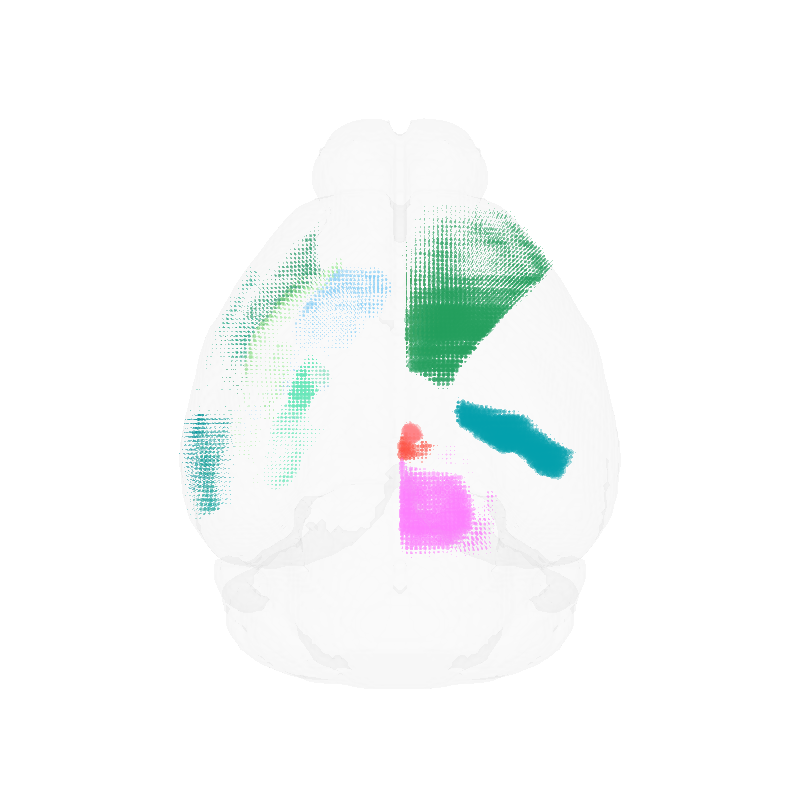

In [30]:
#3D mapping of C-FOS cubes (3D mappings for Figure 6C, Figure S6B)

#Example: Supplemental Figure S6B WT ctrl

#loading structure list for ploting
volume_based_analysis = pd.read_csv("table_s1.csv", index_col =0)
ipsilateral_list = volume_based_analysis[volume_based_analysis["Ipsi. volume-based analysis oChIEF U test P value"]<0.05].index.tolist()
contralateral_list = volume_based_analysis[volume_based_analysis["Contra. volume-based analysis oChIEF U test P value"]<0.05].index.tolist()

#3D mapping
def vedo_cfos (df, structure_list_contra, structure_list_ipsi):
    root = vedo.load("root_small.vtk")
    root.cmap("gray_r").alpha(0.1).lighting("ambient")

    model = [root]

    for a in structure_list_contra:
        contra_structure = df[(df["hemisphere"]=="Left")&(df["structure"]==a)]
        if len(contra_structure)>0:
            pts_contra = [(contra_structure["z(micrometer)"][indexa], contra_structure["y(micrometer)"][indexa], contra_structure["x(micrometer)"][indexa]) for indexa, varaa in contra_structure.iterrows()]
            color_contra = vedo.colors.build_palette(np.unique(contra_structure["color"].values)[0], np.unique(contra_structure["color"].values)[0], 2)
            contra_s = vedo.Spheres(pts_contra, r = contra_structure["norm_size"].tolist(), alpha= 0.2, res = 10).cmap(color_contra).lighting("off")

            model.append(contra_s)

    for b in structure_list_ipsi:
        ipsi_structure = df[(df["hemisphere"]=="Right")&(df["structure"]==b)]
        if len(ipsi_structure)>0:
            pts_ipsi = [(ipsi_structure["z(micrometer)"][indexb], ipsi_structure["y(micrometer)"][indexb], ipsi_structure["x(micrometer)"][indexb]) for indexb, varab in ipsi_structure.iterrows()]
            color_ipsi = vedo.colors.build_palette(np.unique(ipsi_structure["color"].values)[0], np.unique(ipsi_structure["color"].values)[0], 2)
            ipsi_s = vedo.Spheres(pts_ipsi, r = ipsi_structure["size"].tolist(), alpha= 0.2, res = 10).cmap(color_ipsi).lighting("off")

            model.append(ipsi_s)

    return model

cfos_model = vedo_cfos (WT_cfos_ctrl_spot_down_sub, contralateral_list, ipsilateral_list)

#show 3D mapping
vedo.settings.default_backend = '2d' #set to 'k3d' for interactive plotting
vedo.show(cfos_model, azimuth=0, elevation=-90, roll=270, resetcam = True, zoom = 1, size=(800, 800))

In [31]:
#create delta C-FOS spots
#Example Figure 7B left panel

DMN_list = ["ACAd", "ACAv", "PL", "ILA", "ORBl", "ORBm", "ORBvl", 
            "VISa", "VISam", "RSPagl", "RSPd", "RSPv", 
            "SSp-tr", "SSp-ll", "MOs"]

def cfos_spot_diff (df1_u, df2_u, hemisphere_u, structure_list):
    pd_diff_all = pd.DataFrame()
    for structure in structure_list:

        df1_structure = df1_u[(df1_u["hemisphere"]==hemisphere_u)&(df1_u["structure"]==structure)]
        df2_structure = df2_u[(df2_u["hemisphere"]==hemisphere_u)&(df2_u["structure"]==structure)]
        df1_structure["xyz"]=[(varaa["z(micrometer)"], varaa["y(micrometer)"], varaa["x(micrometer)"]) for indexa, varaa in df1_structure.iterrows()]
        df2_structure["xyz"]=[(varaa["z(micrometer)"], varaa["y(micrometer)"], varaa["x(micrometer)"]) for indexa, varaa in df2_structure.iterrows()]
        df1_structure.set_index(["xyz"], inplace = True)
        df2_structure.set_index(["xyz"], inplace = True)
        common_xyz = list(set(df1_structure.index.tolist()).intersection(set(df2_structure.index.tolist())))
        diff = df2_structure.loc[common_xyz, "Density (cells/cubic millimeter)"]-df1_structure.loc[common_xyz, "Density (cells/cubic millimeter)"]
        diff_pd = pd.DataFrame({"xyz":common_xyz, "diff":diff.tolist()})
        diff_pd["structure"]=structure
        diff_pd["hemisphere"]=hemisphere_u
        pd_diff_all = pd.concat([pd_diff_all, diff_pd], axis =0)
    return pd_diff_all

contra_WT_Tbr1_ctrl = cfos_spot_diff(WT_cfos_ctrl_spot_down_sub, Tbr1_cfos_ctrl_spot_down_sub, "Left", DMN_list)
ipsi_WT_Tbr1_ctrl = cfos_spot_diff(WT_cfos_ctrl_spot_down_sub, Tbr1_cfos_ctrl_spot_down_sub, "Right", DMN_list)

WT_Tbr1_ctrl = pd.concat([contra_WT_Tbr1_ctrl, ipsi_WT_Tbr1_ctrl])

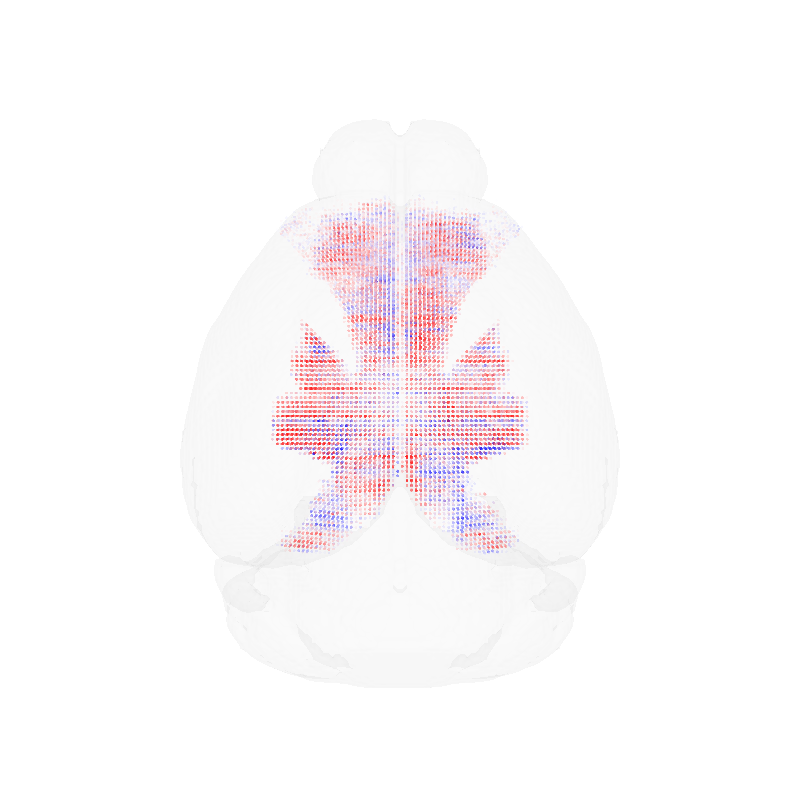

In [33]:
#3D mapping of delta C-FOS (3D mappings for Figure 7B, graphic summary B, C)
#Example Figure 7B left panel

xyz_list = WT_Tbr1_ctrl["xyz"].tolist()
diff_list = WT_Tbr1_ctrl["diff"].tolist()

vmin, vmax = np.min(diff_list), np.max(diff_list)
scale = abs(vmax-vmin)
scale_diff = diff_list/scale
min_value = min(scale_diff)
max_value = max(scale_diff)

color = [vedo.color_map(v, "bwr", -0.1, 0.1) for v in scale_diff]

s = vedo.Spheres(xyz_list, r = 30, alpha= 0.2, res = 10, c = color).lighting("off")

root = vedo.load("root_small.vtk")
root.cmap("gray_r").alpha(0.1).lighting("ambient")

#show 3D mapping
vedo.settings.default_backend = '2d' #set to 'k3d' for interactive plotting
vedo.show(root, s, azimuth=0, elevation=-90, roll=270, zoom = 1, size = (800, 800))

In [34]:
#create delta delta cfos spots
#Example:Figure 4C middle left panel

ipsi_list = ['HIP', 'MOp', 'AUDd', 'ACA', 'ACAv', 'VISa', 'TEa', 'MEA',
             'PALv', 'SI', 'PALc', 'BST', 'DORsm', 'DORpm', 'CL', 'LZ', 'VTA']

def delta_delta_cfos_spot_diff (WT_nost_df, WT_TBS_df, Tbr1_nost_df, Tbr1_TBS_df, hemisphere, structure_list):


    def cfos_spot_diff (df1_u, df2_u, hemisphere_u, structure_u):

        df1_structure = df1_u[(df1_u["hemisphere"]==hemisphere_u)&(df1_u["structure"]==structure_u)]
        df2_structure = df2_u[(df2_u["hemisphere"]==hemisphere_u)&(df2_u["structure"]==structure_u)]
        df1_structure["xyz"]=[(varaa["z(micrometer)"], varaa["y(micrometer)"], varaa["x(micrometer)"]) for indexa, varaa in df1_structure.iterrows()]
        df2_structure["xyz"]=[(varaa["z(micrometer)"], varaa["y(micrometer)"], varaa["x(micrometer)"]) for indexa, varaa in df2_structure.iterrows()]
        df1_structure.set_index(["xyz"], inplace = True)
        df2_structure.set_index(["xyz"], inplace = True)
        common_xyz = list(set(df1_structure.index.tolist()).intersection(set(df2_structure.index.tolist())))
        diff = df2_structure.loc[common_xyz, "Density (cells/cubic millimeter)"]-df1_structure.loc[common_xyz, "Density (cells/cubic millimeter)"]
        diff_pd = pd.DataFrame({"xyz":common_xyz, "diff":diff.tolist()})
        return diff_pd
    
    pd_diff_all = pd.DataFrame()
    for structure in structure_list:
        diff_WT = cfos_spot_diff(WT_nost_df, WT_TBS_df, hemisphere, structure)
        diff_Tbr1 = cfos_spot_diff(Tbr1_nost_df, Tbr1_TBS_df, hemisphere, structure)
        diff_WT.set_index(["xyz"], inplace = True)
        diff_Tbr1.set_index(["xyz"], inplace = True)
        com_xyz = list(set(diff_WT.index.tolist()).intersection(set(diff_Tbr1.index.tolist())))
        diff_Tbr1_WT = diff_Tbr1.loc[com_xyz, "diff"]-diff_WT.loc[com_xyz, "diff"]
        pd_structure = pd.DataFrame({"xyz": com_xyz, "diff": diff_Tbr1_WT.tolist()})
        pd_structure["structure"]=structure
        pd_diff_all = pd.concat([pd_diff_all, pd_structure], axis =0)
    return pd_diff_all

ipsi_cfos_diff = delta_delta_cfos_spot_diff (WT_cfos_ctrl_spot_down_sub,
                                             WT_cfos_TBS_spot_down_sub,
                                             Tbr1_cfos_ctrl_spot_down_sub,
                                             Tbr1_cfos_TBS_spot_down_sub,
                                             "Right",
                                             ipsi_list)

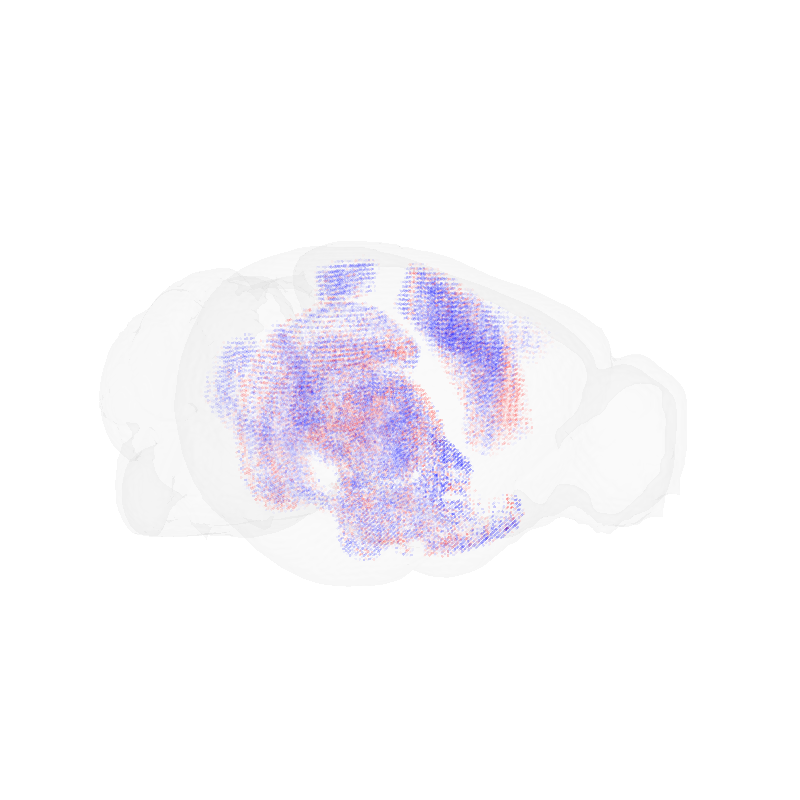

In [37]:
#3D mapping of delta delta C-FOS (3D mappings for Figure 4A,C)
#Example Figure 4C middle left panel

xyz_list = ipsi_cfos_diff["xyz"].tolist()
diff_list = ipsi_cfos_diff["diff"].tolist()

vmin, vmax = np.min(diff_list), np.max(diff_list)
scale = abs(vmax-vmin)
scale_diff = diff_list/scale
min_value = min(scale_diff)
max_value = max(scale_diff)

color = [vedo.color_map(v, "bwr", -0.1, 0.1) for v in scale_diff]

s = vedo.Spheres(xyz_list, r = 30, alpha= 0.1, res = 10, c = color).lighting("off")

root = vedo.load("root_small.vtk")
root.cmap("gray_r").alpha(0.1).lighting("ambient")

#show 3D mapping
vedo.settings.default_backend ='2d'
vedo.show(root, s, azimuth=-20, elevation=-10, roll=180, zoom = 1, size = (800, 800))

In [43]:
#constructure ancestor center node  

area_list = ["Prefrontal", "Somatomotor", "Medial", "Lateral", "Auditory", "Visual", "Olfactory areas", "Hippocampal formation", "Cortical subplate", 
                 "Cerebral nuclei", "Thalamus", "Hypothalamus", "Midbrain", "Hindbrain"]

def create_centroid_df (df, structure_name):
    contra_df = df[df["hemisphere"]=="Left"]
    ipsi_df = df[df["hemisphere"]=="Right"]


    x_center_list_contra=[]
    y_center_list_contra=[]
    z_center_list_contra=[]
    for a in area_list:
        contra_structure =contra_df[contra_df[structure_name]==a]
        x_center_contra = (np.sum(contra_structure["x(micrometer)"].values))/len(contra_structure["x(micrometer)"].values)
        y_center_contra = (np.sum(contra_structure["y(micrometer)"].values))/len(contra_structure["y(micrometer)"].values)
        z_center_contra= (np.sum(contra_structure["z(micrometer)"].values))/len(contra_structure["z(micrometer)"].values)
        x_center_list_contra.append(x_center_contra)
        y_center_list_contra.append(y_center_contra)
        z_center_list_contra.append(z_center_contra)


    x_center_list_ipsi=[]
    y_center_list_ipsi=[]
    z_center_list_ipsi=[]
    for b in area_list:
        ipsi_structure =ipsi_df[ipsi_df[structure_name]==b]
        x_center_ipsi = (np.sum(ipsi_structure["x(micrometer)"].values))/len(ipsi_structure["x(micrometer)"].values)
        y_center_ipsi = (np.sum(ipsi_structure["y(micrometer)"].values))/len(ipsi_structure["y(micrometer)"].values)
        z_center_ipsi= (np.sum(ipsi_structure["z(micrometer)"].values))/len(ipsi_structure["z(micrometer)"].values)
        x_center_list_ipsi.append(x_center_ipsi)
        y_center_list_ipsi.append(y_center_ipsi)
        z_center_list_ipsi.append(z_center_ipsi)

    contra_center= pd.DataFrame({"x_center":x_center_list_contra,
                                "y_center":y_center_list_contra,
                                "z_center":z_center_list_contra,
                                "structure":area_list})
    contra_center["hemisphere"]="Left"
    ipsi_center= pd.DataFrame({"x_center":x_center_list_ipsi,
                                "y_center":y_center_list_ipsi,
                                "z_center":z_center_list_ipsi,
                                "structure":area_list})
    ipsi_center["hemisphere"]="Right"

    pd_center = pd.concat([ipsi_center, contra_center])

    return pd_center 


WT_cfos_ctrl_center = create_centroid_df(WT_cfos_ctrl_spot_down_sub, "area")
Tbr1_cfos_ctrl_center = create_centroid_df (Tbr1_cfos_ctrl_spot_down_sub, "area")
WT_cfos_TBS_center = create_centroid_df(WT_cfos_TBS_spot_down_sub, "area")
Tbr1_cfos_TBS_center = create_centroid_df(Tbr1_cfos_TBS_spot_down_sub, "area")

WT_cfos_ctrl_center["color"] = [area_color_dict[a] for a in WT_cfos_ctrl_center["structure"].tolist()]
Tbr1_cfos_ctrl_center["color"] = [area_color_dict[a] for a in Tbr1_cfos_ctrl_center["structure"].tolist()]
WT_cfos_TBS_center["color"] = [area_color_dict[a] for a in WT_cfos_TBS_center["structure"].tolist()]
Tbr1_cfos_TBS_center["color"] = [area_color_dict[a] for a in Tbr1_cfos_TBS_center["structure"].tolist()]


In [45]:
#mean correlation within and between brain areas

#loading C-FOS correlation martix (data will be avaiable after publication)
WT_ctrl_com = pd.read_csv ("correlation/WT_ctrl.csv", index_col = 0)
Tbr1_ctrl_com = pd.read_csv ("correlation/Tbr1_ctrl.csv", index_col = 0)
WT_TBS_com = pd.read_csv ("correlation/WT_TBS.csv", index_col = 0)
Tbr1_TBS_com = pd.read_csv ("correlation/Tbr1_TBS.csv", index_col = 0)

#add areas
parent_structure = pd.read_csv ("CCFv3/structuretree/structure_list_paper_cfos.csv", index_col = 0)

structure_list = list(WT_ctrl_com["structure"])
label_list = list(parent_structure["LABEL"])
label_dict = {si : i for i,si in enumerate(label_list)}
index_list = list(itemgetter(*structure_list)(label_dict))
WT_ctrl_com["area"] = parent_structure.iloc[index_list]["area"].tolist()
Tbr1_ctrl_com["area"] = parent_structure.iloc[index_list]["area"].tolist()
WT_TBS_com["area"] = parent_structure.iloc[index_list]["area"].tolist()
Tbr1_TBS_com["area"] = parent_structure.iloc[index_list]["area"].tolist()


WT_ctrl_com["area"] = [str("i_")+ a for a in WT_ctrl_com[WT_ctrl_com["hemisphere"]=="ipsi"]["area"].tolist()]+[str("c_")+ a for a in WT_ctrl_com[WT_ctrl_com["hemisphere"]=="contra"]["area"].tolist()]
Tbr1_ctrl_com["area"] = [str("i_")+ a for a in Tbr1_ctrl_com[Tbr1_ctrl_com["hemisphere"]=="ipsi"]["area"].tolist()]+[str("c_")+ a for a in Tbr1_ctrl_com[Tbr1_ctrl_com["hemisphere"]=="contra"]["area"].tolist()]
WT_TBS_com["area"] = [str("i_")+ a for a in WT_TBS_com[WT_TBS_com["hemisphere"]=="ipsi"]["area"].tolist()]+[str("c_")+ a for a in WT_TBS_com[WT_TBS_com["hemisphere"]=="contra"]["area"].tolist()]
Tbr1_TBS_com["area"] = [str("i_")+ a for a in Tbr1_TBS_com[Tbr1_TBS_com["hemisphere"]=="ipsi"]["area"].tolist()]+[str("c_")+ a for a in Tbr1_TBS_com[Tbr1_TBS_com["hemisphere"]=="contra"]["area"].tolist()]


In [59]:
#formation of area correlation table

area_list_ic = ["i_Prefrontal", "i_Somatomotor", "i_Medial", "i_Lateral", "i_Auditory", "i_Visual", "i_Olfactory areas", "i_Hippocampal formation", "i_Cortical subplate", 
                 "i_Cerebral nuclei", "i_Thalamus", "i_Hypothalamus", "i_Midbrain", "i_Hindbrain",
                 "c_Prefrontal", "c_Somatomotor", "c_Medial", "c_Lateral", "c_Auditory", "c_Visual", "c_Olfactory areas", "c_Hippocampal formation", "c_Cortical subplate", 
                 "c_Cerebral nuclei", "c_Thalamus", "c_Hypothalamus", "c_Midbrain", "c_Hindbrain"]
def area_mean_corr(df):
    df_c = df.copy()
    community_list = area_list_ic
    for indexa, varaa in df.iterrows():
        df.loc[indexa, indexa]=np.nan
    df_area = pd.DataFrame(index = community_list, columns = community_list)
    for a in community_list:
        com_index = df.loc[df["area"]==a].index.tolist()
        for b in community_list:
            com_column = df.loc[df["area"]==b].index.tolist()
            df_sp = df.loc[com_index,com_column]
            #if not (len(pd.melt(df_sp))==1)&(com_index==com_column):
            mean_corr = np.mean (df_sp.mean())
            df_c.loc[com_index,com_column]=mean_corr
            df_area.loc[a,b] = mean_corr.astype("float")
    rearange_index = df_c.sort_values(by=["area"]).index.tolist()
    return df_c.loc[rearange_index,rearange_index], df_area

WT_ctrl_com_mean, WT_ctrl_com_area = area_mean_corr(WT_ctrl_com)
Tbr1_ctrl_com_mean, Tbr1_ctrl_com_area= area_mean_corr(Tbr1_ctrl_com)
WT_TBS_com_mean, WT_TBS_com_area= area_mean_corr(WT_TBS_com)
Tbr1_TBS_com_mean, Tbr1_TBS_com_area= area_mean_corr(Tbr1_TBS_com)
WT_ctrl_com_area["mean_correlation"] = [WT_ctrl_com_area.loc[a,a] for a in area_list_ic]
Tbr1_ctrl_com_area["mean_correlation"] = [Tbr1_ctrl_com_area.loc[a,a] for a in area_list_ic]
WT_TBS_com_area["mean_correlation"] = [WT_TBS_com_area.loc[a,a] for a in area_list_ic]
Tbr1_TBS_com_area["mean_correlation"] = [Tbr1_TBS_com_area.loc[a,a] for a in area_list_ic]
WT_ctrl_com_area.replace(0, np.nan, inplace=True)
Tbr1_ctrl_com_area.replace(0, np.nan, inplace=True)
WT_TBS_com_area.replace(0, np.nan, inplace=True)
Tbr1_TBS_com_area.replace(0, np.nan, inplace=True)

def df_to_network_area (df):
    df_network = nx.from_pandas_adjacency(df.iloc[:,:-1])
    df_network.remove_edges_from(nx.selfloop_edges(df_network))
    for n, d in df_network.nodes(data = True):
        d["mean_correlation"] = df["mean_correlation"][n]
    return df_network
WT_ctrl_area_network = df_to_network_area(WT_ctrl_com_area)
Tbr1_ctrl_area_network = df_to_network_area(Tbr1_ctrl_com_area)
WT_TBS_area_network = df_to_network_area(WT_TBS_com_area)
Tbr1_TBS_area_network = df_to_network_area(Tbr1_TBS_com_area)

WT_cfos_ctrl_center["mean_correlation"]=WT_ctrl_com_area["mean_correlation"].tolist()
Tbr1_cfos_ctrl_center["mean_correlation"]=Tbr1_ctrl_com_area["mean_correlation"].tolist()
WT_cfos_TBS_center["mean_correlation"]=WT_TBS_com_area["mean_correlation"].tolist()
Tbr1_cfos_TBS_center["mean_correlation"]=Tbr1_TBS_com_area["mean_correlation"].tolist()

def add_location_to_correlation_table (df_center, df_network):
    correlation_table = utils.edge_table(df_network)

    source_location = []
    target_location = []

    for a in correlation_table["source"].tolist():
        if a[:1]=="i":
            location_df = df_center[(df_center["hemisphere"]=="Right")&(df_center["structure"]==a[2:])]
            if (len(location_df)>0):
                location = [location_df["z_center"].tolist()[0], location_df["y_center"].tolist()[0], location_df["x_center"].tolist()[0]]
        elif a[:1]=="c":
            location_df = df_center[(df_center["hemisphere"]=="Left")&(df_center["structure"]==a[2:])]
            if (len(location_df)>0):
                location = [location_df["z_center"].tolist()[0], location_df["y_center"].tolist()[0], location_df["x_center"].tolist()[0]]
        else:
            location = np.nan
        source_location.append(location)

    for b in correlation_table["target"].tolist():
        if b[:1]=="i":
            location_t_df = df_center[(df_center["hemisphere"]=="Right")&(df_center["structure"]==b[2:])]
            if (len(location_t_df)>0):
                location_t = [location_df["z_center"].tolist()[0], location_df["y_center"].tolist()[0], location_df["x_center"].tolist()[0]]
        elif b[:1]=="c":
            location_t_df = df_center[(df_center["hemisphere"]=="Left")&(df_center["structure"]==b[2:])]
            if (len(location_t_df)>0):
                location_t = [location_df["z_center"].tolist()[0], location_df["y_center"].tolist()[0], location_df["x_center"].tolist()[0]]
        else:
            location_t = np.nan
        
        target_location.append(location_t)
        
    correlation_table["source_location"]= source_location
    correlation_table["target_location"]= target_location

    return correlation_table

WT_ctrl_correlation_table = add_location_to_correlation_table(WT_cfos_ctrl_center, WT_ctrl_area_network)
Tbr1_ctrl_correlation_table = add_location_to_correlation_table(Tbr1_cfos_ctrl_center, Tbr1_ctrl_area_network)
WT_TBS_correlation_table = add_location_to_correlation_table(WT_cfos_TBS_center, WT_TBS_area_network)
Tbr1_TBS_correlation_table = add_location_to_correlation_table(Tbr1_cfos_TBS_center, Tbr1_TBS_area_network)

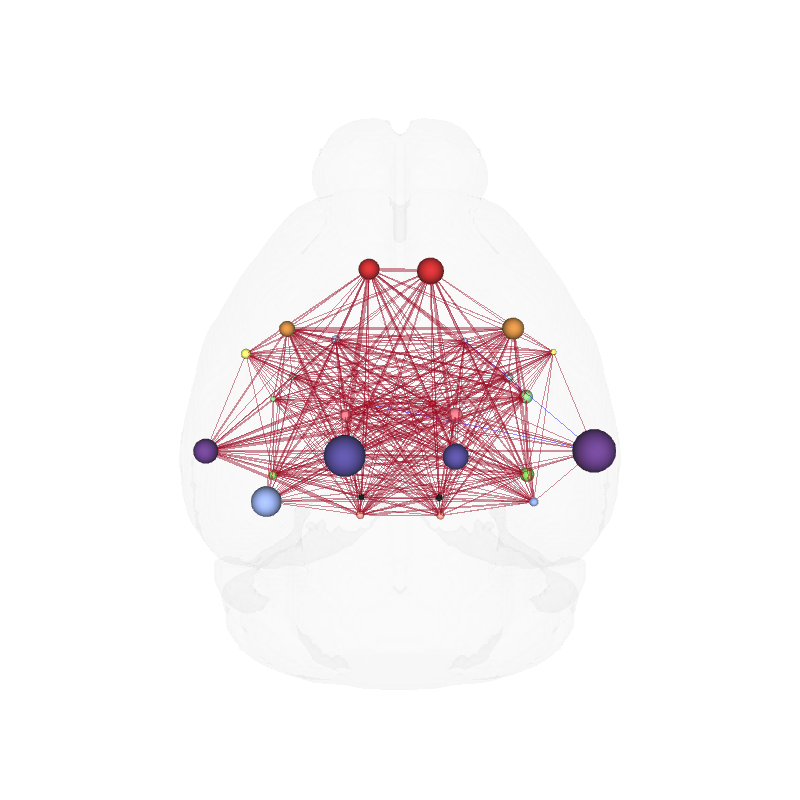

In [62]:
#3D mapping of C-FOS mean correlation network amon major brain areas
#Example: graphic summary D WT ctrl

area_list = ["Prefrontal", "Somatomotor", "Medial", "Lateral", "Auditory", "Visual", "Olfactory areas", "Hippocampal formation", "Cortical subplate", 
                 "Cerebral nuclei", "Thalamus", "Hypothalamus", "Midbrain", "Hindbrain"]

def vedo_cfos_network (df, structure_list_contra, structure_list_ipsi):
    root = vedo.load("root_small.vtk")
    root.cmap("gray_r").alpha(0.1).lighting("ambient")

    model = [root]

    for a in structure_list_contra:
        contra_structure = df[(df["hemisphere"]=="Left")&(df["structure"]==a)]
        if len(contra_structure)>0:
            pts_contra = [(contra_structure["z_center"][indexa], contra_structure["y_center"][indexa], contra_structure["x_center"][indexa]) for indexa, varaa in contra_structure.iterrows()]
            color_contra = vedo.colors.build_palette(np.unique(contra_structure["color"].values)[0], np.unique(contra_structure["color"].values)[0], 2)
            
            contra_s = vedo.Spheres(pts_contra, r = contra_structure["mean_correlation"]*700, alpha= 1, res = 10).cmap(color_contra).lighting("default")

            model.append(contra_s)

    for b in structure_list_ipsi:
        ipsi_structure = df[(df["hemisphere"]=="Right")&(df["structure"]==b)]
        if len(ipsi_structure)>0:
            pts_ipsi = [(ipsi_structure["z_center"][indexb], ipsi_structure["y_center"][indexb], ipsi_structure["x_center"][indexb]) for indexb, varab in ipsi_structure.iterrows()]
            color_ipsi = vedo.colors.build_palette(np.unique(ipsi_structure["color"].values)[0], np.unique(ipsi_structure["color"].values)[0], 2)
            ipsi_s = vedo.Spheres(pts_ipsi, r = ipsi_structure["mean_correlation"]*700, alpha= 1, res = 10).cmap(color_ipsi).lighting("default")

            model.append(ipsi_s)

    return model

cfos_model = vedo_cfos_network (WT_cfos_ctrl_center, area_list , area_list)

def vedo_line_model (correlation_table):

    loc_num = [int(s) for s in np.arange(len(correlation_table)/2)*2]
    line_model =[]
    for a in loc_num:
        source_list =[varaa["source_location"] for indexa, varaa in correlation_table.iloc[a:a+2, :].iterrows()]
        target_list =[varaa["target_location"] for indexa, varaa in correlation_table.iloc[a:a+2, :].iterrows()]
        if np.mean(correlation_table.iloc[a:a+2, :]["weight"])>0:
            line = vedo.Line(p0=source_list, p1 = target_list, lw=abs(np.mean(correlation_table.iloc[a:a+2, :]["weight"]))*10, res = 5, c = "#890017", alpha = 0.5)
        elif np.mean(correlation_table.iloc[a:a+2, :]["weight"])<0:
            line = vedo.Line(p0=source_list, p1 = target_list, lw=abs(np.mean(correlation_table.iloc[a:a+2, :]["weight"]))*10, res = 5, c = "blue", alpha = 0.5)
        line_model.append(line)
    return line_model

cfos_line_model = vedo_line_model(WT_ctrl_correlation_table)

#show 3D mapping
vedo.settings.default_backend ='2d'
vedo.show(cfos_model, cfos_line_model, azimuth=0, elevation=-90, roll=270, resetcam = True, zoom = 1, size=(800, 800))